In [ ]:
import os # path processing
from time import perf_counter # timer

# Đọc dữ liệu từ file

In [ ]:
def readFile(name_file):
    images = []
    for line in open(name_file).read():
        images.append(line)
    return images;

In [ ]:
# This for loop is converting spaces into 0  and  # and + are getting converted into 1
def convertCharToNumber(arr_images):
    list_temp = []
    for char in arr_images:
        if char == ' ':
            list_temp.append(0)
        elif char == '+' or char == '#':
            list_temp.append(1)
        else:
            continue
    return list_temp

In [ ]:
def getFeature(list_train_or_test):
    lis = list()
    image_arr = list()
    for index in range(0,len(list_train_or_test)):
        if index == len(list_train_or_test) - 1:
            lis.append(list_train_or_test[index])
            image_arr.append(lis)
        elif ( index % 784 ==0 and index!=0):
            image_arr.append(lis)
            lis = list() #new
            lis.append(list_train_or_test[index])
        else:
            lis.append(list_train_or_test[index])
    return image_arr

In [ ]:
def getLabel(label_array):
  list_label = []
  for i in label_array:
    if i != '\n':
        list_label.append(int(i))
  return list_label


# File Loader
## Get feature

In [ ]:
training_images = readFile("trainingimages")
list_training = convertCharToNumber(training_images)
img_arr_train= getFeature(list_training)


testing_images =  readFile("testimages")
list_testing = convertCharToNumber(testing_images)
img_arr_test = getFeature(list_testing)

## Get label

In [ ]:
label_train = readFile("traininglabels")
lb_arr_train = getLabel(label_train)

label_test = readFile("testlabels")
lb_arr_test = getLabel(label_test)

In [ ]:
lb_arr_train[:10]

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]

# Load and saving model system

In [ ]:
# save the model to disk
import pickle # save train model
def save_model(obj, filename):
    filename = os.path.join(os.path.abspath('./'), filename + ".sav")
    pickle_file = open(filename, 'wb')
    pickle.dump(obj, pickle_file)
    pickle_file.close()

def load_model(filename):
    file_path = os.path.join(os.path.abspath('./'), filename)
    loaded_model = pickle.load(open(file_path, 'rb'))
    return loaded_model

# Model
Phần lý thuyết và các bước thiết kế nhóm em đã trình bày chi tiết trong file doc. <br>
Dưới đây là một class giúp thuận tiện việc save model.


 

In [ ]:
from math import log
class Model:
  def __init__(self, k = 0.2):
    self.k = k #Laplace Smoothing
    self.priors = []
    self.number_of={}
    self.P_zerosfor = {}
    self.P_onesfor = {}

  def fit(self, X_train, y_train, X_test, y_test):
    self.n_classes = self.numberLabel(y_train)
    # Tính Prior từng class: Xác suất độc lập với Feature
    for c in range(self.n_classes):
      self.priors.append(y_train.count(c)/len(y_train))
    
    # Tính Likelihood
    for c in range(self.n_classes):
      new_array = []
      for i in range(0,len(y_train)):
        if y_train[i]==c:
          new_array.append(X_train[i])
      self.number_of[c] = new_array
    
    # Tính xác suất phân của features thuộc vào class c
    for c in range(self.n_classes):
      temp_zeros_array = []
      temp_ones_array = []
      for pixel in range(0,784):
        count_0 = 0
        count_1 = 0
        for each_image in self.number_of[c]:
          if each_image[pixel] == 0:
            count_0 = count_0 + 1
          elif each_image[pixel] == 1:
            count_1 = count_1 + 1
        prob_0=(self.k+count_0)/(2*self.k+len(self.number_of[c]))
        prob_1=(self.k+count_1)/(2*self.k+len(self.number_of[c]))
        temp_zeros_array.append(prob_0)
        temp_ones_array.append(prob_1)
      self.P_zerosfor[c] = temp_zeros_array
      self.P_onesfor[c] = temp_ones_array
    return self

  #Make prediction - highest probility is the prediction
  #postirior = likeihood * prior
  def predict(self, y_test):
    predicted_label = list()
    Log_P = {}
    for each_test_image in y_test:
      prob_image=[]
      for c in range(self.n_classes):
        Log_P[c] = log(self.priors[c])
        for index in range(0,len(each_test_image)):
          takeprob = 0
          if each_test_image[index] == 0:
            takeprob = self.P_zerosfor[c][index]
          elif each_test_image[index] == 1:
            takeprob = self.P_onesfor[c][index]
          Log_P[c]+=log(takeprob)  #fix floating point
        prob_image.append(Log_P[c])
      x = prob_image.index(max(prob_image))
      predicted_label.append(x)
    return predicted_label

  # đếm số label khác nhau
  def numberLabel(self, list_classes):
    unique_class = []
    count = 0
    for x in list_classes:
      if x not in unique_class:
        count += 1
        unique_class.append(x)
    return count
  
  # Predict label dựa theo 1 features trong tập X_test
  def checkModel(self, X_test):
    prob_image=[]
    Log_P = {}
    for c in range(self.n_classes):
      Log_P[c] = log(self.priors[c])
      for index in range(0,len(X_test)):
        takeprob = 0
        if X_test[index] == 0:
          takeprob = self.P_zerosfor[c][index]
        elif X_test[index] == 1:
          takeprob = self.P_onesfor[c][index]
        Log_P[c]+=log(takeprob)  #fix floating point
      prob_image.append(Log_P[c])
    x = prob_image.index(max(prob_image))
    return x


# Training Model và Save Model

In [ ]:
model = Model(k=0.0005)
model.fit(img_arr_train, lb_arr_train, img_arr_test,lb_arr_test )

In [ ]:
save_model(model, "train_full")

# Dự đoán label với tập X_test

In [ ]:
predicted_label = model.predict(img_arr_test)

# Đánh giá mô hình

In [ ]:
# Accuracy
def Acc(predicted_label, lb_arr_test):
  return len([i for i, j in zip(lb_arr_test, predicted_label) if i == j]) / len(lb_arr_test)

In [ ]:
print(Acc(predicted_label, lb_arr_test))

0.774


# Load model từ file

In [ ]:
model_k = load_model("train_full.sav")

In [ ]:
predicted_model_k = model_k.predict(img_arr_test)

In [ ]:
model.checkModel(img_arr_test[11])

1

In [ ]:
lb_arr_test[11]

1

# Tìm Laplace Smoothing sao cho accuracy tốt

In [ ]:
# k_i = 0.1
Acc_k = {}
for i in range(0, 10, 1):
  print('Khi k = ', i)
  model = Model(k=i + 0.1)
  model.fit(img_arr_train, lb_arr_train, img_arr_test,lb_arr_test )
  predicted_label = model.predict(img_arr_test)
  Acc_k[i] = Acc(predicted_label, lb_arr_test)
  print('Acc: ' , Acc(predicted_label, lb_arr_test))

Khi k =  0
Acc:  0.773
Khi k =  1
Acc:  0.771
Khi k =  2
Acc:  0.765
Khi k =  3
Acc:  0.763
Khi k =  4
Acc:  0.761
Khi k =  5
Acc:  0.758
Khi k =  6
Acc:  0.758
Khi k =  7
Acc:  0.755
Khi k =  8
Acc:  0.755
Khi k =  9
Acc:  0.755


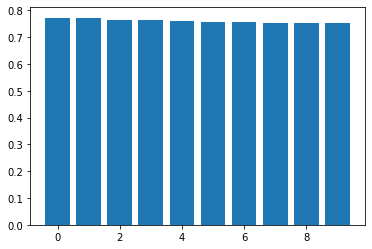

In [ ]:
import matplotlib.pyplot as plt
plt.bar(*zip(*Acc_k.items()))
plt.show()

# Đánh giá bằng K-cross Validation

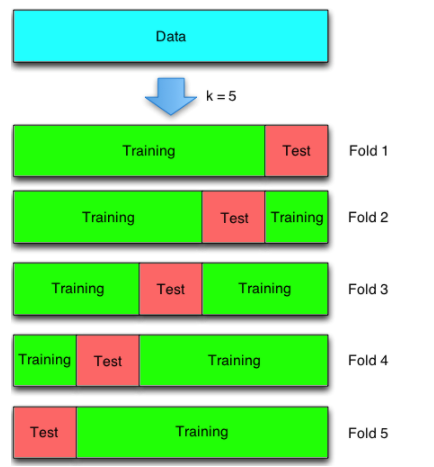

In [ ]:
k = 10
accuracy_list = []
fold_idx = 1
n = (int) (len(img_arr_train)/k)
for i in range(0, len(img_arr_train), n):
  model = Model(k=k_i)
  X_val_k = img_arr_train[i:i+n]
  y_val_k = lb_arr_train[i:i+n]
  X_train_k = img_arr_train[:i] + img_arr_train[i+n:]
  y_train_k = lb_arr_train[:i] + lb_arr_train[i+n:]
  model.fit(X_train_k, y_train_k, img_arr_test,lb_arr_test )
  predicted_label = model.predict(X_val_k)
  accuracy_list.append(Acc(predicted_label, y_val_k))
  print("Đã train xong Fold ", fold_idx)
  # Sang Fold tiếp theo
  fold_idx = fold_idx + 1

Đã train xong Fold  1
Đã train xong Fold  2
Đã train xong Fold  3
Đã train xong Fold  4
Đã train xong Fold  5
Đã train xong Fold  6
Đã train xong Fold  7
Đã train xong Fold  8
Đã train xong Fold  9
Đã train xong Fold  10


Trong bài tập này, em chia thành 10 Folds, ý tưởng là mỗi fold sẽ lấy ra các phần tử theo index set để đưa vào train và val cho phù hợp. Kết quả accuracy sẽ được lưu lại vào một list để hiển thị và tính trung bình cộng.

In [ ]:
# In kết quả tổng thể
import numpy as np
print('* Chi tiết các fold')
for i in range(0, len(accuracy_list)):
  print(f'> Fold {i+1} - Accuracy: {accuracy_list[i]}%')

print('* Đánh giá tổng thể các folds:')
print(f'> Accuracy: {np.mean(accuracy_list)} (Độ lệch +- {np.std(accuracy_list)})')

* Chi tiết các fold
> Fold 1 - Accuracy: 0.846%
> Fold 2 - Accuracy: 0.788%
> Fold 3 - Accuracy: 0.806%
> Fold 4 - Accuracy: 0.864%
> Fold 5 - Accuracy: 0.83%
> Fold 6 - Accuracy: 0.84%
> Fold 7 - Accuracy: 0.812%
> Fold 8 - Accuracy: 0.842%
> Fold 9 - Accuracy: 0.826%
> Fold 10 - Accuracy: 0.824%
* Đánh giá tổng thể các folds:
> Accuracy: 0.8278000000000001 (Độ lệch +- 0.020793268141396124)


# Confusionmatrix

In [ ]:
def confusionmatrix(actual, predicted, normalize = False):
    unique = sorted(set(actual))
    matrix = [[0 for _ in unique] for _ in unique]
    imap   = {key: i for i, key in enumerate(unique)}
    # Generate Confusion Matrix
    for p, a in zip(predicted, actual):
        matrix[imap[p]][imap[a]] += 1
    # Matrix Normalization
    if normalize:
        sigma = sum([sum(matrix[imap[i]]) for i in unique])
        matrix = [row for row in map(lambda i: list(map(lambda j: j / sigma, i)), matrix)]
    return matrix

In [ ]:
cf_matrix = confusionmatrix(lb_arr_test, predicted_label)

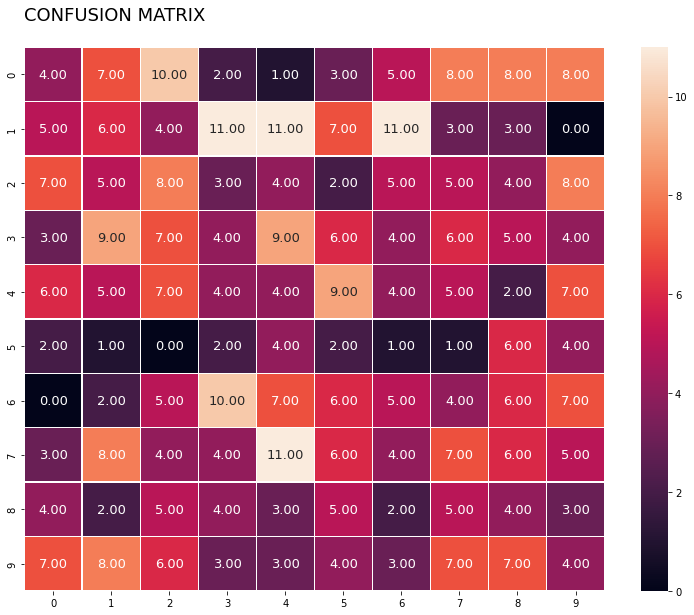

In [ ]:
fig, ax = plt.subplots(figsize=(13,10))
import seaborn as sns
sns.heatmap(data=cf_matrix, annot=True, annot_kws={"fontsize":13}, fmt=".2f", 
            linecolor='white', linewidths=0.5);

title = 'CONFUSION MATRIX\n'
ax.set_title(title, loc='left', fontsize=18);

Khi sử dụng 2 tập dữ liệu training và testing để đánh thuật toán ta được độ chính xác tổng thể là 78%. Nhìn vào confusion matrix ta có thấy một vài vị trí nhầm lẫn trong việc dự đoán nhãn. Ví dụ: (5, 3) ,(8,3) hay (4, 9)… là những vị trí có kết quả khá cao hay là bị nhầm lẫn cao.

# Accuracy of each digit

In [ ]:
def AccOfClass(predict, val):
  return (len([i for i, j in zip(val, predict) if i == j]) / len(val))*100

In [ ]:
acc_of = {}
predicted_label_of = {} 
for c in range(10):
  img_array = []
  lb_array = []
  for i in range(0,len(lb_arr_test)):
    if lb_arr_test[i]==c:
      img_array.append(img_arr_test[i])
      lb_array.append(lb_arr_test[i])
  predicted_label_of[c] = model.predict(img_array)
  acc_of[c] = AccOfClass(predicted_label_of[c], lb_array)

In [ ]:
for c, pe in acc_of.items():
  print('Digit:',c , 'Accuracy: ', pe,'%')

In [ ]:
plt.bar(*zip(*acc_of.items()))
plt.show()